In [66]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### State

In [67]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage


class AgentState(TypedDict):
    messages: Annotated[
        Sequence[BaseMessage], operator.add
    ]  # Agent 간 공유하는 메시지 목록
    sender: Annotated[str, "The sender of the last message"]  # 마지막 메시지의 발신자

In [68]:
state1 = AgentState(
    messages=[
        HumanMessage(content='대한민국의 수도는 어디야?'),
        AIMessage(content='서울입니다.')
    ],
    sender="AI"
)

### 도구 정의

In [69]:
from typing import Annotated

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL


tavily_tool = TavilySearch(max_results=1)   # Tavily 검색 도구 정의
python_repl = PythonREPL()                  # Python 코드를 실행하는 도구 정의


@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""

    print('===== python_repl_tool() 함수 시작 =====')

    try:        
        result = python_repl.run(code)      # 코드 실행 결과
    except BaseException as e:
        return f"Failed to execute code. Error: {repr(e)}"
    
    # 실행 성공 시 결과와 함께 성공 메시지 리턴
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    
    print(f'결과: ')
    print(result_str)
    print('===== python_repl_tool() 함수 끝 =====')

    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [70]:
python_repl_tool.invoke({'code': "print(1+2)"})

===== python_repl_tool() 함수 시작 =====
결과: 
Successfully executed:
```python
print(1+2)
```
Stdout: 3

===== python_repl_tool() 함수 끝 =====


'Successfully executed:\n```python\nprint(1+2)\n```\nStdout: 3\n\n\nIf you have completed all tasks, respond with FINAL ANSWER.'

### Agent 생성

**Research Agent** : `TavilySearch` 도구를 사용하여 연구를 수행하는 에이전트를 생성.

In [71]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [72]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.prebuilt import create_react_agent
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import MessagesState

In [73]:
llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o', 
    temperature=0
)


# Research Agent 생성
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

### Research Agent 노드 정의

In [74]:
def research_node(state: MessagesState) -> MessagesState:
    print('===== research_node() 함수 시작 =====')

    result = research_agent.invoke(state)

    print(f'research_agent 에이전트 실행 결과: ')
    print(result)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(content=result["messages"][-1].content, name="researcher")

    print(f'마지막 메시지를 HumanMessage 로 변환: {last_message}')

    print('===== research_node() 함수 끝 =====')

    return {
        "messages": [last_message]          # Research Agent 의 메시지 목록 반환
    }         

In [75]:
state2= AgentState(
    messages=[
        HumanMessage(content='대한민국의 수도는 어디야?'),
    ],
    sender="Human"
)

research_node(state2)

===== research_node() 함수 시작 =====
research_agent 에이전트 실행 결과: 
{'messages': [HumanMessage(content='대한민국의 수도는 어디야?', additional_kwargs={}, response_metadata={}, id='b097e193-b79d-4913-abaa-ad494b9e63db'), AIMessage(content='대한민국의 수도는 서울입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 199, 'total_tokens': 209, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-b7500a3e-fede-4c11-9f1a-16457a9eb01f-0', usage_metadata={'input_tokens': 199, 'output_tokens': 10, 'total_tokens': 209, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
마지막 메시지를 HumanMessage 로 변환: content='대한민국의 수도는 서울입니다.' a

{'messages': [HumanMessage(content='대한민국의 수도는 서울입니다.', additional_kwargs={}, response_metadata={}, name='researcher')]}

### Chart Generator Agent

`PythonREPL` 도구를 사용하여 차트를 생성하는 에이전트를 생성

In [76]:
chart_generator_system_prompt = """
You can only generate charts. You are working with a researcher colleague.
Be sure to use the following font code in your code when generating charts.
"""

chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    state_modifier=make_system_prompt(chart_generator_system_prompt),
)

In [77]:
def chart_node(state: MessagesState) -> MessagesState:
    print('===== chart_node() 함수 시작 =====')

    result = chart_agent.invoke(state)

    print('chart_agent 에이전트 실행: 결과')
    print(result)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    
    print(f'마지막 메시지를 HumanMessage 로 변환: {last_message}')
    print('===== chart_node() 함수 끝 =====')

    return {"messages": [last_message]}         # 차트 에이전트의 내부 메시지 기록을 다른 에이전트와 공유합니다

In [78]:
state3= AgentState(
    messages=[
        HumanMessage(content='1부터 10까지의 합계를 구하는 파이썬 코드를 작성해줘.'),
    ],
    sender="Human"
)

research_node(state3)

===== research_node() 함수 시작 =====
research_agent 에이전트 실행 결과: 
{'messages': [HumanMessage(content='1부터 10까지의 합계를 구하는 파이썬 코드를 작성해줘.', additional_kwargs={}, response_metadata={}, id='309da157-db57-483a-9f1b-4cc7b46591ea'), AIMessage(content='1부터 10까지의 합계를 구하는 파이썬 코드는 다음과 같습니다:\n\n```python\ntotal = sum(range(1, 11))\nprint(total)\n```\n\n이 코드는 `range(1, 11)`을 사용하여 1부터 10까지의 숫자를 생성하고, `sum()` 함수를 사용하여 이 숫자들의 합계를 계산합니다. `print(total)`은 결과를 출력합니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 211, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-8c91c54d-901d-4e7e-b6eb-35c025999653-0', usage_metadata={'input_tokens': 211, 'o

{'messages': [HumanMessage(content='1부터 10까지의 합계를 구하는 파이썬 코드는 다음과 같습니다:\n\n```python\ntotal = sum(range(1, 11))\nprint(total)\n```\n\n이 코드는 `range(1, 11)`을 사용하여 1부터 10까지의 숫자를 생성하고, `sum()` 함수를 사용하여 이 숫자들의 합계를 계산합니다. `print(total)`은 결과를 출력합니다.', additional_kwargs={}, response_metadata={}, name='researcher')]}

In [79]:
from langgraph.graph import StateGraph, START, END

In [80]:
def router(state: MessagesState):
    print('===== router() 함수 시작 =====')

    messages = state["messages"]
    last_message = messages[-1]

    print(f'messages: {last_message}')
    
    print('===== router() 함수 끝 =====')

    if "FINAL ANSWER" in last_message.content:
        return END
    
    return "continue"

In [81]:
state4= AgentState(
    messages=[
        HumanMessage(content='FINAL ANSWER: 1부터 10까지의 합계를 구하는 파이썬 코드를 작성해줘.'),
    ],
    sender="Human"
)

router(state4)

===== router() 함수 시작 =====
messages: content='FINAL ANSWER: 1부터 10까지의 합계를 구하는 파이썬 코드를 작성해줘.' additional_kwargs={} response_metadata={}
===== router() 함수 끝 =====


'__end__'

In [82]:
state5= AgentState(
    messages=[
        HumanMessage(content='1부터 10까지의 합계를 구하는 파이썬 코드를 작성해줘.'),
    ],
    sender="Human"
)

router(state5)

===== router() 함수 시작 =====
messages: content='1부터 10까지의 합계를 구하는 파이썬 코드를 작성해줘.' additional_kwargs={} response_metadata={}
===== router() 함수 끝 =====


'continue'

In [83]:
from langchain_core.messages import HumanMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(MessagesState)

workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)

workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)

In [84]:
workflow.add_edge(START, "researcher")

In [85]:
app = workflow.compile(checkpointer=MemorySaver())

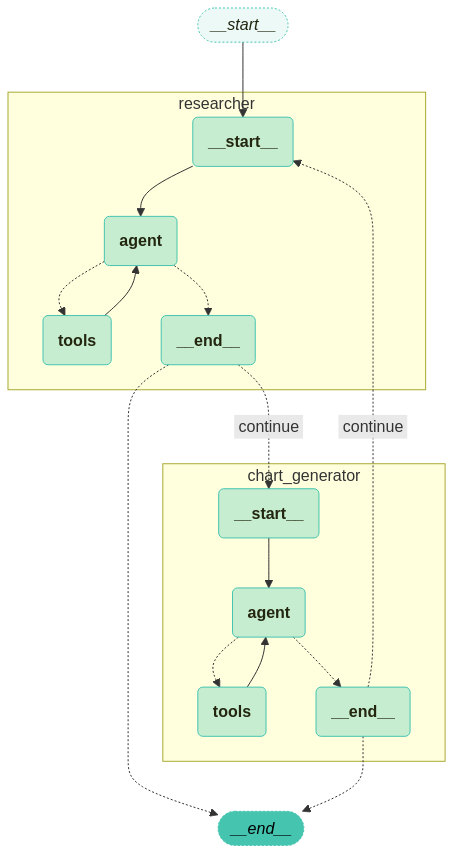

In [86]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)

===== research_node() 함수 시작 =====

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_CcU2O61ilK39uLXb4uJdyQ5p)
 Call ID: call_CcU2O61ilK39uLXb4uJdyQ5p
  Args:
    query: 2010년부터 2024년까지 대한민국 1인당 GDP 데이터
  tavily_web_search (call_4SQFGsyA9C1TkBOQ35TiBc24)
 Call ID: call_4SQFGsyA9C1TkBOQ35TiBc24
  Args:
    query: South Korea GDP per capita 2010 to 2024

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

I found some data on South Korea's GDP per capita from 2010 to 2023, with projections for 2024. Here are some key points:

1. **2010-2023 Data**: The GDP per capita for South Korea has been recorded and analyzed over the years. For instance, in 2023, the GDP per capita was approximately 34,121.02 USD.

2. **2024 Projection**: 

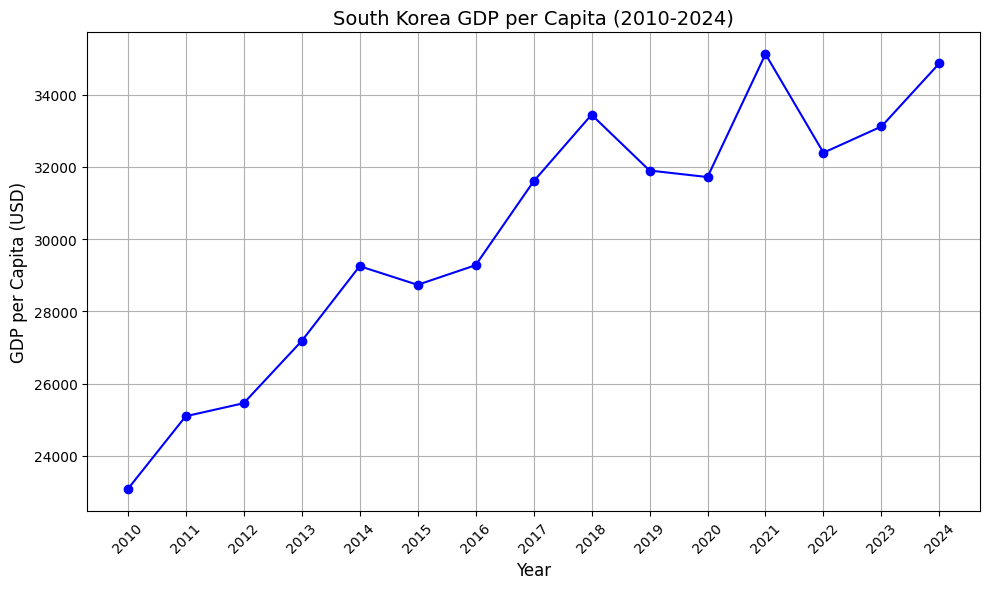

===== python_repl_tool() 함수 시작 =====
결과: 
Successfully executed:
```python
import matplotlib.pyplot as plt

# Data for South Korea's GDP per capita from 2010 to 2024
years = list(range(2010, 2025))
gdp_per_capita = [23079, 25098, 25459, 27180, 29253, 28737, 29280, 31601, 33447, 31902, 31721, 35126, 32395, 33121, 34872]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(years, gdp_per_capita, marker='o', linestyle='-', color='b')
plt.title('South Korea GDP per Capita (2010-2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP per Capita (USD)', fontsize=12)
plt.grid(True)
plt.xticks(years, rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
```
Stdout: 
🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  python_repl_tool (call_xoE1Paq5gnkKrqVS5MronWMM)
 Call ID: call_xoE1Paq5gnkKrqVS5MronWMM
  Args:
    code: import matplotlib.pyp

In [87]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요."
        )
    ],
}

# 그래프 실행
invoke_graph(app, inputs, config, node_names=["researcher", "chart_generator", "agent"])